In [1]:
!pip install geojson_utils

In [2]:
import pandas as pd
import numpy as np
import folium
import requests
import geojson_utils
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

# Restaurant diversity in Boston neighborhoods

In this notebook, we use the Foursquare API to explore restaurants in the neighborhoods of Boston and classify the neighborhoods based on the diversity of their cuisine options.

## Geographical data for Boston neighborhoods

The geographical coordinates for the neighborhoods in Boston are available from the City of Boston: https://data.boston.gov/dataset/boston-neighborhoods. We will load this into the variable `geodata`.

In [3]:
url = 'http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0.geojson'
geodata = requests.get(url).json()
geodata;

`geodata['features']` is a list of dictionaries with information for each neighborhood. We will create a dataframe to store the neighborhood name and geographical coordinates.

The coordinates are given as either a `Polygon` or `MultiPolygon` boundary. `MultiPolygon` coordinates are given as a list of polygons, so the list in total is four layers deep, while `Polygon` coordinates are in a list only three layers deep. To account for this, we add a layer of nesting in the `Polygon` coordinate lists.

We will also store the `Polygon` objects in the dataframe for use with `geojson_utils`, a package that we will use to determine whether a venue falls within the boundaries of a given neighborhood.

In [4]:
df = pd.DataFrame(columns=['neighborhood', 'coordinates'])

for f in geodata['features']:
    coords = f['geometry']['coordinates']
    if f['geometry']['type'] == 'Polygon':
        coords = [coords]
    
    df = df.append({'neighborhood': f['properties']['Name'],
                    'coordinates': coords,
                    'polygon': f['geometry']
                   },
                   ignore_index=True)

In [5]:
df.head()

neighborhood                                        coordinates  \
0     Roslindale  [[[[-71.12592717485386, 42.272013107957406], [...   
1  Jamaica Plain  [[[[-71.10499218689807, 42.326101682808066], [...   
2   Mission Hill  [[[[-71.0904343142608, 42.33576996328494], [-7...   
3       Longwood  [[[[-71.09810894210769, 42.33673037764089], [-...   
4    Bay Village  [[[[-71.06662924918761, 42.34878268384542], [-...   

                                             polygon  
0  {'type': 'MultiPolygon', 'coordinates': [[[[-7...  
1  {'type': 'Polygon', 'coordinates': [[[-71.1049...  
2  {'type': 'Polygon', 'coordinates': [[[-71.0904...  
3  {'type': 'Polygon', 'coordinates': [[[-71.0981...  
4  {'type': 'Polygon', 'coordinates': [[[-71.0666...

We should also find the geographical centers of the neighborhoods, and while we're at it, let's store the geographical area of each neighborhood. We will find these using the below `centroid_area` function (adapted from the `geojson_utils` package).

In [6]:
def centroid_area(coords):
    f_total = 0
    x_total = 0
    y_total = 0
    poly_area = 0

    j = len(coords) - 1
    count = len(coords)

    for i in range(0, count):
        p1_x = coords[i][1]
        p1_y = coords[i][0]
        p2_x = coords[j][1]
        p2_y = coords[j][0]


        f_total = p1_x * p2_y - p2_x * p1_y
        x_total += (p1_x + p2_x) * f_total
        y_total += (p1_y + p2_y) * f_total
        
        poly_area += p1_x * p2_y
        poly_area -= p1_y * p2_x
        j = i
                    
    six_area = poly_area / 2 * 6
    return np.array([y_total / six_area, x_total / six_area]), six_area

To get down to the [longitude, latitude] coordinates, we will have to loop through the outer two list layers. Let's create a new list of coordinates for each neighborhood containing the full list of boundary points (but ignoring the separation of polygons). We then find the centroid and area of these coordinates and store the results in the dataframe.

In [7]:
df['center'] = ''
df['area'] = ''

for i, c in enumerate(df['coordinates']):
    lng_min, lng_max, lat_min, lat_max = 0, -1000, 1000, 0
    
    coords = []
    count = 0
    for j in range(len(c)):
        for k in range(len(c[j])):
            coords.append(np.array(c[j][k])) # collect boundaries for each polygon in the neighborhood
            
    coords = np.concatenate(coords) # make one array of boundary points for the neighborhood
    df['center'][i], df['area'][i] = centroid_area(coords)

In [8]:
df.head()

neighborhood                                        coordinates  \
0     Roslindale  [[[[-71.12592717485386, 42.272013107957406], [...   
1  Jamaica Plain  [[[[-71.10499218689807, 42.326101682808066], [...   
2   Mission Hill  [[[[-71.0904343142608, 42.33576996328494], [-7...   
3       Longwood  [[[[-71.09810894210769, 42.33673037764089], [-...   
4    Bay Village  [[[[-71.06662924918761, 42.34878268384542], [-...   

                                             polygon  \
0  {'type': 'MultiPolygon', 'coordinates': [[[[-7...   
1  {'type': 'Polygon', 'coordinates': [[[-71.1049...   
2  {'type': 'Polygon', 'coordinates': [[[-71.0904...   
3  {'type': 'Polygon', 'coordinates': [[[-71.0981...   
4  {'type': 'Polygon', 'coordinates': [[[-71.0666...   

                                     center         area  
0  [-71.12666256565596, 42.282523940356576]    0.0042553  
1   [-71.11509687004941, 42.30776945995205]   0.00667949  
2  [-71.10260671077644, 42.331741522957486]  0.000930596  
3    [-71.1051033165732, 42.33860925968864]  0.000500324  
4   [-71.06903126349887, 42.34910280642528]  7.04128e-05

## Visualizing neighborhoods

Let's visualize the neighborhoods with a map. To find the geographical center, let's find the average latitude/longitude.

In [9]:
# find average latitude/longitude
lng_avg, lat_avg = df['center'].mean()

m = folium.Map(location=[lat_avg, lng_avg], zoom_start=12)

folium.GeoJson(geodata).add_to(m)

# loop over neighborhoods
for i in range(df.shape[0]):
    s = df['neighborhood'][i]
    label = folium.Popup(s)

    folium.CircleMarker(
        df['center'][i][::-1],
        radius=4,
        color='black',
        fill_color='white',
        fill_opacity=0.5,
        popup=label).add_to(m)  
   
m

The neighborhoods are all clearly different sizes, so we should account for the different areas when using the Foursquare API. Let's use the area we extracted from the polygon coordinates to vizualize the search radius. We use a scaling factor to convert the area (in terms of latitude/longitude) to a physical radius.

In [10]:
m = folium.Map(location=[lat_avg, lng_avg], zoom_start=12)

folium.GeoJson(geodata).add_to(m)

df['radius'] = ''

# loop over neighborhoods
for i in range(df.shape[0]):
    s = df['neighborhood'][i]
    label = folium.Popup(s)
    
    RADIUS = np.sqrt(df['area'][i]) * 20000 # convert to a radius and scale
    df['radius'][i] = RADIUS
    
    folium.Circle(
        df['center'][i][::-1],
        radius=RADIUS, # radius in meters,
        fill_color='black',
        color='black'
    ).add_to(m)
   
m

The search areas overlap minimally while still encompassing most of each neighborhood. The scale factor we chose gives an appropriate search radius. We added the radius to the dataframe, so let's examine it once again.

In [11]:
df.head()

neighborhood                                        coordinates  \
0     Roslindale  [[[[-71.12592717485386, 42.272013107957406], [...   
1  Jamaica Plain  [[[[-71.10499218689807, 42.326101682808066], [...   
2   Mission Hill  [[[[-71.0904343142608, 42.33576996328494], [-7...   
3       Longwood  [[[[-71.09810894210769, 42.33673037764089], [-...   
4    Bay Village  [[[[-71.06662924918761, 42.34878268384542], [-...   

                                             polygon  \
0  {'type': 'MultiPolygon', 'coordinates': [[[[-7...   
1  {'type': 'Polygon', 'coordinates': [[[-71.1049...   
2  {'type': 'Polygon', 'coordinates': [[[-71.0904...   
3  {'type': 'Polygon', 'coordinates': [[[-71.0981...   
4  {'type': 'Polygon', 'coordinates': [[[-71.0666...   

                                     center         area   radius  
0  [-71.12666256565596, 42.282523940356576]    0.0042553  1304.65  
1   [-71.11509687004941, 42.30776945995205]   0.00667949  1634.56  
2  [-71.10260671077644, 42.331741522957486]  0.000930596  610.114  
3    [-71.1051033165732, 42.33860925968864]  0.000500324  447.358  
4   [-71.06903126349887, 42.34910280642528]  7.04128e-05  167.825

## Exploring restaurants in neighborhoods

### Test the API call

We will now use the Foursquare API to explore these neighborhoods. Below is the information needed to make requests to the API.

In [12]:
CLIENT_ID = 'ESQILQUJ45MEFP5CYAUTQAPRNT1YA22FASZDU0VCI5VIE2EP'
CLIENT_SECRET = 'MZIKSDQUL4OHRIPALRKSUQSKUMMVKM2PCGAMGJPWKJ3G0MBZ'
VERSION = '20200415' # Foursquare API version
LIMIT = 100

Let's start by searching for restaurants in the first neighborhood, and then we will loop over neighborhoods once we have confirmed the API call and data cleaning code is working properly. 

To search for restaurants, we will pass the [`categoryId`](https://developer.foursquare.com/docs/build-with-foursquare/categories/) for "Food" (4d4b7105d754a06374d81259) to the API call.


In [13]:
i = 1
lng, lat = df['center'][i]
radius = df['radius'][i]

url = 'https://api.foursquare.com/v2/venues/search?\
                    &client_id={}\
                    &client_secret={}\
                    &v={}\
                    &ll={},{}\
                    &radius={}\
                    &limit={}\
                    &categoryId=4d4b7105d754a06374d81259'.format(
                        CLIENT_ID, 
                        CLIENT_SECRET, 
                        VERSION, 
                        lat, 
                        lng, 
                        radius, 
                        LIMIT)
venues = requests.get(url).json()['response']['venues']
venues;

Because our search areas overlap, we should only keep restaurants that belong to the intended neighborhood. We again employ the `geojson_utils` package, this time calling the `_point_in_polygon` function directly to check if the coordinates of each restaurant fall inside the neighborhood boundary stored in `df['polygon']`.

In [14]:
lat_not_in_polygon, lng_not_in_polygon, name_not_in_polygon = [], [], [] # to store info for venues outside boundary

for v in venues:
    lat, lng = v['location']['lat'], v['location']['lng']
    point = {'coordinates': [lng, lat]}
    if not geojson_utils.point_in_polygon(point, df['polygon'][i]):
        lat_not_in_polygon.append(lat)
        lng_not_in_polygon.append(lng)
        name_not_in_polygon.append(v['name'])
        print(name_not_in_polygon[-1])

Domino's Pizza
McDonald's


We see that it is possible for venues to fall outside the neighborhood boundary. Let's visualize this on the map.

In [15]:
m = folium.Map(location=df['center'][i][::-1], zoom_start=13.5)

# geodata = geodata[geo]
folium.GeoJson(df['polygon'][i]).add_to(m)

s = df['neighborhood'][i]
label = folium.Popup(s)

RADIUS = np.sqrt(df['area'][i]) * 20000 # convert to a radius and scale
df['radius'][i] = RADIUS

folium.Circle(
    df['center'][i][::-1],
    radius=RADIUS, # radius in meters,
    fill_color='black',
    color='black'
).add_to(m)

# Plot the outsider restaurants as reds point
for lat, lng in zip(lat_not_in_polygon, lng_not_in_polygon):
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        fill_color='red',
        color='red'
    ).add_to(m)

# Plot the other venues as green points
for v in venues:
    if v['name'] not in name_not_in_polygon:
        folium.CircleMarker(
        [v['location']['lat'], v['location']['lng']],
        radius=4,
        fill_color='green',
        color='green'
        ).add_to(m)
   
m

First we note that there are venues that lie outside the search radius (probably because of a discrepancy between the definition of the `radius` parameter for Foursquare vs. Folium). Two of these venues (red) also lie outside the neighborhood boundary (blue). We will discard these venues, because they will probably get identified by the search centered in the correct neighborhood.

### Loop over neighborhoods and call API

Now we can loop over the neighborhoods to obtain venue information. Let's store the API responses in a new column in the dataframe.

In [16]:
df['venues'] = ''

for i in range(df.shape[0]):

    print(df['neighborhood'][i])
    lng, lat = df['center'][i]
    radius = df['radius'][i]

    url = 'https://api.foursquare.com/v2/venues/search?\
                    &client_id={}\
                    &client_secret={}\
                    &v={}\
                    &ll={},{}\
                    &radius={}\
                    &limit={}\
                    &categoryId=4d4b7105d754a06374d81259'.format(
                        CLIENT_ID, 
                        CLIENT_SECRET, 
                        VERSION, 
                        lat, 
                        lng, 
                        radius, 
                        LIMIT)
    venues = requests.get(url).json()['response']['venues']
    
    # Remove venues that are not within the neighborhood boundary
    venues2 = [] # store valid venues in this list
    for v in venues:
        lat, lng = v['location']['lat'], v['location']['lng']
        point = {'coordinates': [lng, lat]}
        if geojson_utils.point_in_polygon(point, df['polygon'][i]): # keep venues within boundary
            venues2.append(v)
        
    
    df['venues'][i] = venues2

Roslindale
Jamaica Plain
Mission Hill
Longwood
Bay Village
Leather District
Chinatown
North End
Roxbury
South End
Back Bay
East Boston
Charlestown
West End
Beacon Hill
Downtown
Fenway
Brighton
West Roxbury
Hyde Park
Mattapan
Dorchester
South Boston Waterfront
South Boston
Allston
Harbor Islands


The unprocessed API calls are stored in the dataframe `'venues'` column. We store this here temporarily so we won't have to call the API again.

In [17]:
df.head()

neighborhood                                        coordinates  \
0     Roslindale  [[[[-71.12592717485386, 42.272013107957406], [...   
1  Jamaica Plain  [[[[-71.10499218689807, 42.326101682808066], [...   
2   Mission Hill  [[[[-71.0904343142608, 42.33576996328494], [-7...   
3       Longwood  [[[[-71.09810894210769, 42.33673037764089], [-...   
4    Bay Village  [[[[-71.06662924918761, 42.34878268384542], [-...   

                                             polygon  \
0  {'type': 'MultiPolygon', 'coordinates': [[[[-7...   
1  {'type': 'Polygon', 'coordinates': [[[-71.1049...   
2  {'type': 'Polygon', 'coordinates': [[[-71.0904...   
3  {'type': 'Polygon', 'coordinates': [[[-71.0981...   
4  {'type': 'Polygon', 'coordinates': [[[-71.0666...   

                                     center         area   radius  \
0  [-71.12666256565596, 42.282523940356576]    0.0042553  1304.65   
1   [-71.11509687004941, 42.30776945995205]   0.00667949  1634.56   
2  [-71.10260671077644, 42.331741522957486]  0.000930596  610.114   
3    [-71.1051033165732, 42.33860925968864]  0.000500324  447.358   
4   [-71.06903126349887, 42.34910280642528]  7.04128e-05  167.825   

                                              venues  
0  [{'id': '4d38d28276d1a35d859d018e', 'name': 'T...  
1  [{'id': '5e459a8a70758c00083c0a60', 'name': 'M...  
2  [{'id': '5b50bb1b16fa04002c1ad6f2', 'name': 'S...  
3  [{'id': '59d7c3da419a9e1ec1bc0ea2', 'name': 'S...  
4  [{'id': '5b9c4bedbed483002c0dd034', 'name': 'N...

### Parsing API response

First, let's look at the `'venues'` column in detail.

In [18]:
df['venues'][0];

For each neighborhood, we have a list of dictionaries, each of which containing information about a single venue. We will create a new dataframe where each row contains the neighborhood name, ZIP code, venue name, and venue category.

In [19]:
venues = pd.DataFrame()

count_no_postal_code = 0

for neighborhood, venue_list in zip(df['neighborhood'], df['venues']):
    for venue_dict in venue_list:
        name = venue_dict['name']
        try:
            postal_code = venue_dict['location']['postalCode']
        except:
            count_no_postal_code += 1
            continue
        cat_name = venue_dict['categories'][0]['name']
        venues = venues.append({'neighborhood': neighborhood, 'ZIP': postal_code, 'venue name': name, 'venue type': cat_name}, ignore_index=True)
print(count_no_postal_code, 'venues without ZIP codes')

39 venues without ZIP codes


In [20]:
print(venues.shape)
venues.head()

(907, 4)


ZIP neighborhood     venue name            venue type
0  02131   Roslindale  Triple Eatery    Chinese Restaurant
1  02131   Roslindale            KFC   Fried Chicken Joint
2  02131   Roslindale        Dunkin'            Donut Shop
3  02131   Roslindale  Pleasant Cafe    Italian Restaurant
4  02131   Roslindale     McDonald's  Fast Food Restaurant

We see already that there are multiple locations for some venues within the same neighborhood. Since we are interested in variety, let's drop duplicate entries within each neighborhood.

In [21]:
venues.drop_duplicates(inplace=True)
print(venues.shape)
venues.head()

(852, 4)


ZIP neighborhood     venue name            venue type
0  02131   Roslindale  Triple Eatery    Chinese Restaurant
1  02131   Roslindale            KFC   Fried Chicken Joint
2  02131   Roslindale        Dunkin'            Donut Shop
3  02131   Roslindale  Pleasant Cafe    Italian Restaurant
4  02131   Roslindale     McDonald's  Fast Food Restaurant

Now let's use one-hot encoding to quantify the frequency of occurence for each type of venue in each neighborhood.

In [22]:
onehot = pd.get_dummies(venues[['venue type']], prefix='', prefix_sep='')
onehot = pd.concat([venues['neighborhood'], onehot], axis=1) # add the neighborhood column
grouped = onehot.groupby(['neighborhood']).sum().reset_index() # Group by neighborhood and take the mean to get number of restaurants of each type
grouped.head()

neighborhood  African Restaurant  American Restaurant  Asian Restaurant  \
0      Allston                   0                    0                 0   
1     Back Bay                   0                    3                 0   
2  Bay Village                   0                    0                 0   
3  Beacon Hill                   0                    1                 0   
4     Brighton                   0                    1                 0   

   Australian Restaurant  BBQ Joint  Bagel Shop  Bakery  Bar  Bookstore  ...  \
0                      0          0           0       1    0          0  ...   
1                      0          0           0       2    1          1  ...   
2                      0          0           0       0    0          0  ...   
3                      0          0           0       1    1          0  ...   
4                      0          0           0       0    1          0  ...   

   Tea Room  Thai Restaurant  Theme Restaurant  Turkish Restaurant  \
0         1                1                 0                   0   
1         0                0                 0                   0   
2         0                0                 0                   0   
3         0                1                 0                   0   
4         0                1                 0                   0   

   Udon Restaurant  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  \
0                0                              0                      1   
1                0                              0                      1   
2                0                              0                      0   
3                0                              0                      0   
4                0                              0                      0   

   Whisky Bar  Wine Bar  Wings Joint  
0           0         0            0  
1           0         1            0  
2           0         0            0  
3           0         0            0  
4           0         0            0  

[5 rows x 98 columns]

In [23]:
grouped.shape, df.shape

((25, 98), (26, 7))

We notice that one neighborhood (unsurprisingly, Harbor Islands) does not have any identified venues. Let's be sure to drop this from the geographical information dataframe.

In [24]:
df = df[df.neighborhood != 'Harbor Islands']
df.shape

(25, 7)

Let's plot a bar chart to see the variety of restaurants in the whole of Boston.

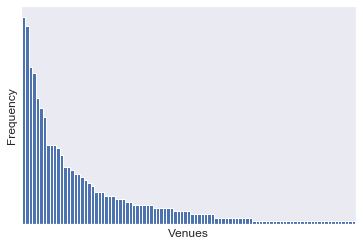

In [25]:
ax = grouped.drop(columns=['neighborhood']).sum().sort_values(ascending=False).plot.bar(width=1)
ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel('Venues')
ax.set_ylabel('Frequency')

ax.figure.savefig('./report/summary_bar.pdf', bbox_inches='tight')

Get some examples for the most common and least common venue types:

In [26]:
grouped.drop(columns=['neighborhood']).sum().sort_values(ascending=False)

Coffee Shop             66
Pizza Place             63
Café                    50
Italian Restaurant      48
Bakery                  40
                        ..
Gay Bar                  1
Frozen Yogurt Shop       1
Fish & Chips Shop        1
Ethiopian Restaurant     1
Hotpot Restaurant        1
Length: 97, dtype: int64

## Data analysis

### Filtering results

Let's inspect the venue types to see if we should exclude any.

In [27]:
grouped.columns

Index(['neighborhood', 'African Restaurant', 'American Restaurant',
       'Asian Restaurant', 'Australian Restaurant', 'BBQ Joint', 'Bagel Shop',
       'Bakery', 'Bar', 'Bookstore', 'Breakfast Spot', 'Brewery',
       'Bubble Tea Shop', 'Buffet', 'Burger Joint', 'Burrito Place',
       'Cafeteria', 'Café', 'Cajun / Creole Restaurant',
       'Caribbean Restaurant', 'Chinese Restaurant', 'Cocktail Bar',
       'Coffee Shop', 'College Cafeteria', 'Convenience Store', 'Creperie',
       'Deli / Bodega', 'Dessert Shop', 'Dim Sum Restaurant', 'Diner',
       'Donut Shop', 'Ethiopian Restaurant', 'Falafel Restaurant',
       'Fast Food Restaurant', 'Fish & Chips Shop', 'Food', 'Food Court',
       'Food Truck', 'French Restaurant', 'Fried Chicken Joint',
       'Frozen Yogurt Shop', 'Gastropub', 'Gay Bar', 'Gourmet Shop',
       'Greek Restaurant', 'Grocery Store', 'Halal Restaurant',
       'Historic Site', 'Hot Dog Joint', 'Hotpot Restaurant', 'Ice Cream Shop',
       'Indian Restaurant'

In the following, we drop bars, grocery stores, and generic venue types like "Food" and "Restaurant."

In [28]:
grouped_filtered = grouped.drop(columns=['Bar', 'Bookstore', 'Cocktail Bar', 
              'Convenience Store', 'Food', 'Food Court', 'Gay Bar', \
              'Gourmet Shop','Grocery Store', 'Historic Site', 'Karaoke Bar', \
              'Liquor Store', 'Market', 'Music Venue', 'Pet Store', \
              'Residential Building (Apartment / Condo)', 'Restaurant', \
              'Whisky Bar', 'Wine Bar'])

In [29]:
grouped_filtered.head()

neighborhood  African Restaurant  American Restaurant  Asian Restaurant  \
0      Allston                   0                    0                 0   
1     Back Bay                   0                    3                 0   
2  Bay Village                   0                    0                 0   
3  Beacon Hill                   0                    1                 0   
4     Brighton                   0                    1                 0   

   Australian Restaurant  BBQ Joint  Bagel Shop  Bakery  Breakfast Spot  \
0                      0          0           0       1               0   
1                      0          0           0       2               1   
2                      0          0           0       0               0   
3                      0          0           0       1               1   
4                      0          0           0       0               1   

   Brewery  ...  Taco Place  Tapas Restaurant  Tea Room  Thai Restaurant  \
0        0  ...           1                 0         1                1   
1        0  ...           0                 0         0                0   
2        0  ...           0                 0         0                0   
3        0  ...           0                 0         0                1   
4        0  ...           0                 1         0                1   

   Theme Restaurant  Turkish Restaurant  Udon Restaurant  \
0                 0                   0                0   
1                 0                   0                0   
2                 0                   0                0   
3                 0                   0                0   
4                 0                   0                0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wings Joint  
0                              0                      1            0  
1                              0                      1            0  
2                              0                      0            0  
3                              0                      0            0  
4                              0                      0            0  

[5 rows x 79 columns]

This eliminated 19 types of venues.

A good "diversity" metric for comparing neighborhoods based on restaurant diversity is the following:
$$
\text{Diversity} = \frac{\text{Number of unique restaurant types}}{\text{Total number of restaurants}}.
$$
We calculate this and add it as a column to the dataframe.

In [30]:
grouped_tmp = grouped.drop(columns=['neighborhood'])
N_unique = grouped_tmp[grouped_tmp != 0].count(axis=1) # count every entry that is not zero.
N_total = grouped_tmp.sum(axis=1) # total number

try: # for rerunning cell
    grouped_filtered.drop(columns='diversity', inplace=True)
except:
    pass
    
grouped_filtered.insert(1, 'diversity', N_unique/N_total)
grouped_filtered.head()

neighborhood  diversity  African Restaurant  American Restaurant  \
0      Allston   0.634146                   0                    0   
1     Back Bay   0.585366                   0                    3   
2  Bay Village   0.750000                   0                    0   
3  Beacon Hill   0.714286                   0                    1   
4     Brighton   0.666667                   0                    1   

   Asian Restaurant  Australian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                 0                      0          0           0       1   
1                 0                      0          0           0       2   
2                 0                      0          0           0       0   
3                 0                      0          0           0       1   
4                 0                      0          0           0       0   

   Breakfast Spot  ...  Taco Place  Tapas Restaurant  Tea Room  \
0               0  ...           1                 0         1   
1               1  ...           0                 0         0   
2               0  ...           0                 0         0   
3               1  ...           0                 0         0   
4               1  ...           0                 1         0   

   Thai Restaurant  Theme Restaurant  Turkish Restaurant  Udon Restaurant  \
0                1                 0                   0                0   
1                0                 0                   0                0   
2                0                 0                   0                0   
3                1                 0                   0                0   
4                1                 0                   0                0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wings Joint  
0                              0                      1            0  
1                              0                      1            0  
2                              0                      0            0  
3                              0                      0            0  
4                              0                      0            0  

[5 rows x 80 columns]

Let's see the distribution of this diversity index across all neighborhoods.

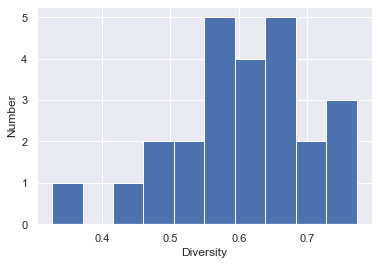

In [31]:
ax = grouped_filtered.hist(column='diversity')
ax[0,0].set_xlabel('Diversity')
ax[0,0].set_ylabel('Number')
ax[0,0].set_title('')

ax[0,0].figure.savefig('report/diversity_hist.pdf', bbox_inches='tight')

In [32]:
grouped_filtered['diversity'].describe()

count    25.000000
mean      0.606448
std       0.104822
min       0.326531
25%       0.564103
50%       0.625000
75%       0.666667
max       0.772727
Name: diversity, dtype: float64

Great, so there is a broad range of neighborhoods with varying diversity, but it's not clear how to organize them. For that, we turn to clustering.

### Blind clustering

As a start, let's just blindly cluster the neighborhoods based on the frequency of each venue type. We will use the $k$-means algorithm and choose the optimal $k$ using the "elbow" method.

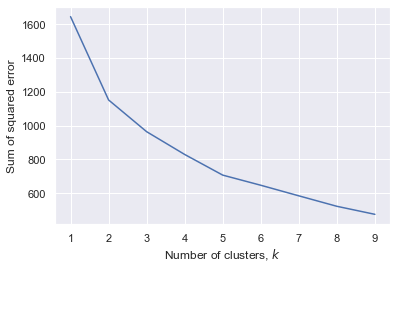

In [33]:
errors = []
ks = list(range(1,10))

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0)\
                .fit(grouped_filtered.drop(columns=['neighborhood', 'diversity']))
    errors.append(kmeans.inertia_)
    
fig, ax = plt.subplots()
ax.plot(ks, errors)
ax.set_xlabel('Number of clusters, $k$')
ax.set_ylabel('Sum of squared error')

ax.annotate('"Elbow"', xy=(3,2), xytext=(3,5), arrowprops=dict(color='k', width=1), ha='center', va='top')

fig.savefig('report/elbow.pdf', bbox_inches='tight')

This plot shows that as the number of clusters increases, the total "distance" between data points and the cluster centers (in "venue type" space) decreases as we include more clusters. The improvement in the fit slows down at the "elbow" of the plot ($k=3$), suggesting that we should cluster the neighborhoods into three groups. Let's add the labels from the 3-cluster results to the dataframe.

In [34]:
kmeans = KMeans(n_clusters=3, random_state=0)\
         .fit(grouped_filtered.drop(columns=['neighborhood', 'diversity']))

In [35]:
grouped_filtered.insert(1, 'labels', kmeans.labels_)
grouped_filtered.head()

neighborhood  labels  diversity  African Restaurant  American Restaurant  \
0      Allston       1   0.634146                   0                    0   
1     Back Bay       1   0.585366                   0                    3   
2  Bay Village       1   0.750000                   0                    0   
3  Beacon Hill       1   0.714286                   0                    1   
4     Brighton       0   0.666667                   0                    1   

   Asian Restaurant  Australian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                 0                      0          0           0       1   
1                 0                      0          0           0       2   
2                 0                      0          0           0       0   
3                 0                      0          0           0       1   
4                 0                      0          0           0       0   

   ...  Taco Place  Tapas Restaurant  Tea Room  Thai Restaurant  \
0  ...           1                 0         1                1   
1  ...           0                 0         0                0   
2  ...           0                 0         0                0   
3  ...           0                 0         0                1   
4  ...           0                 1         0                1   

   Theme Restaurant  Turkish Restaurant  Udon Restaurant  \
0                 0                   0                0   
1                 0                   0                0   
2                 0                   0                0   
3                 0                   0                0   
4                 0                   0                0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wings Joint  
0                              0                      1            0  
1                              0                      1            0  
2                              0                      0            0  
3                              0                      0            0  
4                              0                      0            0  

[5 rows x 81 columns]

Let's look at the top 5 restaurant types for each neighborhood within each cluster.

In [36]:
df_top5 = pd.DataFrame() # new dataframe for the top 5 restaurant types in each neighborhood

label = 0
for i, (n, label) in enumerate(zip(grouped_filtered['neighborhood'], grouped_filtered['labels'])):
    # sort venues in each neighborhood based on frequency
    freq = grouped_filtered.drop(columns=['neighborhood', 'labels', 'diversity']) \
        .iloc[i, 2:].sort_values(ascending=False)
    dict_top5 = {
        'venue type %i' %j: freq.index[j] for j in range(5)
    }
    dict_top5['neighborhood'] = n
    dict_top5['label'] = label
    df_top5 = df_top5.append(dict_top5, ignore_index=True)

df_top5 = df_top5.astype({'label': int})
df_top5.groupby(['label', 'neighborhood']).first()

venue type 0             venue type 1  \
label neighborhood                                                             
0     Brighton                          Pizza Place                     Café   
      Charlestown                              Café              Pizza Place   
      Dorchester                        Pizza Place                     Café   
      Hyde Park                         Pizza Place                   Bakery   
      Longwood                                 Café              Coffee Shop   
      Mattapan                          Pizza Place     Caribbean Restaurant   
      Mission Hill                      Pizza Place               Donut Shop   
      West End                                 Café              Pizza Place   
1     Allston                   Fried Chicken Joint        Korean Restaurant   
      Back Bay                          Coffee Shop       Italian Restaurant   
      Bay Village                Italian Restaurant               Steakhouse   
      Beacon Hill                       Pizza Place              Coffee Shop   
      Chinatown                  Chinese Restaurant          Bubble Tea Shop   
      Downtown                          Coffee Shop       Seafood Restaurant   
      East Boston                Seafood Restaurant             Burger Joint   
      Fenway                            Coffee Shop          Thai Restaurant   
      Jamaica Plain                     Coffee Shop                   Bakery   
      Leather District             Asian Restaurant              Coffee Shop   
      Roslindale                             Bakery              Pizza Place   
      Roxbury                  Fast Food Restaurant      Fried Chicken Joint   
      South Boston                            Diner  New American Restaurant   
      South Boston Waterfront    Seafood Restaurant       Mexican Restaurant   
      South End                  Italian Restaurant               Donut Shop   
      West Roxbury             Fast Food Restaurant       Italian Restaurant   
2     North End                  Italian Restaurant              Pizza Place   

                                          venue type 2  \
label neighborhood                                       
0     Brighton                             Coffee Shop   
      Charlestown                        Deli / Bodega   
      Dorchester                 Vietnamese Restaurant   
      Hyde Park                   Caribbean Restaurant   
      Longwood                          Sandwich Place   
      Mattapan                    Fast Food Restaurant   
      Mission Hill                       Deli / Bodega   
      West End                      Mexican Restaurant   
1     Allston                              Coffee Shop   
      Back Bay                             Salad Place   
      Bay Village                       Sandwich Place   
      Beacon Hill                    French Restaurant   
      Chinatown                                 Bakery   
      Downtown                            Burger Joint   
      East Boston                          Pizza Place   
      Fenway                        Italian Restaurant   
      Jamaica Plain            New American Restaurant   
      Leather District                  Sandwich Place   
      Roslindale                    Chinese Restaurant   
      Roxbury                            Deli / Bodega   
      South Boston                         Pizza Place   
      South Boston Waterfront              Coffee Shop   
      South End                                 Bakery   
      West Roxbury                          Bagel Shop   
2     North End                                 Bakery   

                                          venue type 3  \
label neighborhood                                       
0     Brighton                            Burger Joint   
      Charlestown                          Coffee Shop   
      Dorchester                  Fast Food Restaurant   
      Hyde Park      

The three clusters are very clearly distinct in terms of the most common restaurants:
* pizza places, cafés and coffee shops
* more diversity
* one neighborhood (North End) known for its Italian food

One cluster looks promising - we see a lot of diversity in the restaurants. But are the neighborhood really diverse enough? Can we narrow down the choices further? 

Let's examine the distribution of diversity metrics in each cluster.

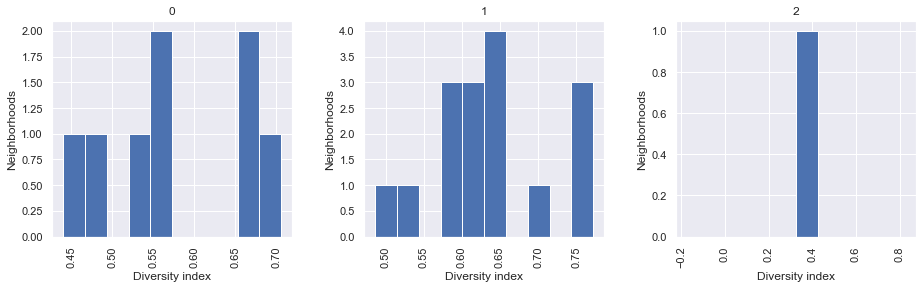

In [37]:
ax = grouped_filtered.hist(column='diversity', by='labels', figsize=(15,4), layout=(1,3))
for a in ax.flatten():
    a.set_xlabel('Diversity index')
    a.set_ylabel('Neighborhoods')
fig = a.figure
fig.savefig('report/hist_counts.pdf', bbox_inches='tight')

Cluster 2 (North End) indeed as a relatively low diversity index. However, there are neighborhoods in both clusters 0 and 1 that have high diversity indices.

### Cluster using proportions of restaurant types.

We will change the clustering to instead use the proportion of restaurants of each type rather than the number. This will allow a more direct comparison between neighborhoods with differing numbers of restaurants.

In [38]:
grouped_filtered.drop(columns='labels', inplace=True)

In [39]:
grouped_filtered.head()

neighborhood  diversity  African Restaurant  American Restaurant  \
0      Allston   0.634146                   0                    0   
1     Back Bay   0.585366                   0                    3   
2  Bay Village   0.750000                   0                    0   
3  Beacon Hill   0.714286                   0                    1   
4     Brighton   0.666667                   0                    1   

   Asian Restaurant  Australian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                 0                      0          0           0       1   
1                 0                      0          0           0       2   
2                 0                      0          0           0       0   
3                 0                      0          0           0       1   
4                 0                      0          0           0       0   

   Breakfast Spot  ...  Taco Place  Tapas Restaurant  Tea Room  \
0               0  ...           1                 0         1   
1               1  ...           0                 0         0   
2               0  ...           0                 0         0   
3               1  ...           0                 0         0   
4               1  ...           0                 1         0   

   Thai Restaurant  Theme Restaurant  Turkish Restaurant  Udon Restaurant  \
0                1                 0                   0                0   
1                0                 0                   0                0   
2                0                 0                   0                0   
3                1                 0                   0                0   
4                1                 0                   0                0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wings Joint  
0                              0                      1            0  
1                              0                      1            0  
2                              0                      0            0  
3                              0                      0            0  
4                              0                      0            0  

[5 rows x 80 columns]

In [40]:
# get total number of restaurants per neighborhood
num_rest = grouped_filtered.drop(columns='diversity').sum(axis=1)

# divide each row by the total
grouped_filtered.iloc[:, 2:] = grouped_filtered.iloc[:, 2:].divide(num_rest, axis='rows')
grouped_filtered.head()

neighborhood  diversity  African Restaurant  American Restaurant  \
0      Allston   0.634146                 0.0             0.000000   
1     Back Bay   0.585366                 0.0             0.081081   
2  Bay Village   0.750000                 0.0             0.000000   
3  Beacon Hill   0.714286                 0.0             0.052632   
4     Brighton   0.666667                 0.0             0.033333   

   Asian Restaurant  Australian Restaurant  BBQ Joint  Bagel Shop    Bakery  \
0               0.0                    0.0        0.0         0.0  0.026316   
1               0.0                    0.0        0.0         0.0  0.054054   
2               0.0                    0.0        0.0         0.0  0.000000   
3               0.0                    0.0        0.0         0.0  0.052632   
4               0.0                    0.0        0.0         0.0  0.000000   

   Breakfast Spot  ...  Taco Place  Tapas Restaurant  Tea Room  \
0        0.000000  ...    0.026316          0.000000  0.026316   
1        0.027027  ...    0.000000          0.000000  0.000000   
2        0.000000  ...    0.000000          0.000000  0.000000   
3        0.052632  ...    0.000000          0.000000  0.000000   
4        0.033333  ...    0.000000          0.033333  0.000000   

   Thai Restaurant  Theme Restaurant  Turkish Restaurant  Udon Restaurant  \
0         0.026316               0.0                 0.0              0.0   
1         0.000000               0.0                 0.0              0.0   
2         0.000000               0.0                 0.0              0.0   
3         0.052632               0.0                 0.0              0.0   
4         0.033333               0.0                 0.0              0.0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wings Joint  
0                            0.0               0.026316          0.0  
1                            0.0               0.027027          0.0  
2                            0.0               0.000000          0.0  
3                            0.0               0.000000          0.0  
4                            0.0               0.000000          0.0  

[5 rows x 80 columns]

Text(0, 0.5, 'Sum of squared error')

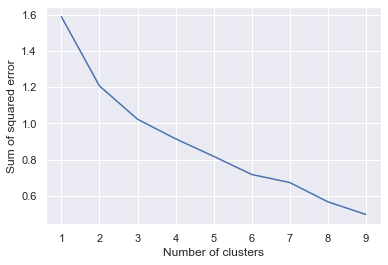

In [41]:
errors = []
ks = list(range(1,10))

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0)\
                .fit(grouped_filtered.drop(columns=['neighborhood', 'diversity']))
    errors.append(kmeans.inertia_)
    
fig, ax = plt.subplots()
ax.plot(ks, errors)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Sum of squared error')

In [42]:
kmeans = KMeans(n_clusters=3, random_state=0)\
         .fit(grouped_filtered.drop(columns=['neighborhood', 'diversity']))

In [43]:
grouped_filtered.insert(1, 'labels', kmeans.labels_)
grouped_filtered.head()

neighborhood  labels  diversity  African Restaurant  American Restaurant  \
0      Allston       2   0.634146                 0.0             0.000000   
1     Back Bay       2   0.585366                 0.0             0.081081   
2  Bay Village       0   0.750000                 0.0             0.000000   
3  Beacon Hill       1   0.714286                 0.0             0.052632   
4     Brighton       1   0.666667                 0.0             0.033333   

   Asian Restaurant  Australian Restaurant  BBQ Joint  Bagel Shop    Bakery  \
0               0.0                    0.0        0.0         0.0  0.026316   
1               0.0                    0.0        0.0         0.0  0.054054   
2               0.0                    0.0        0.0         0.0  0.000000   
3               0.0                    0.0        0.0         0.0  0.052632   
4               0.0                    0.0        0.0         0.0  0.000000   

   ...  Taco Place  Tapas Restaurant  Tea Room  Thai Restaurant  \
0  ...    0.026316          0.000000  0.026316         0.026316   
1  ...    0.000000          0.000000  0.000000         0.000000   
2  ...    0.000000          0.000000  0.000000         0.000000   
3  ...    0.000000          0.000000  0.000000         0.052632   
4  ...    0.000000          0.033333  0.000000         0.033333   

   Theme Restaurant  Turkish Restaurant  Udon Restaurant  \
0               0.0                 0.0              0.0   
1               0.0                 0.0              0.0   
2               0.0                 0.0              0.0   
3               0.0                 0.0              0.0   
4               0.0                 0.0              0.0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wings Joint  
0                            0.0               0.026316          0.0  
1                            0.0               0.027027          0.0  
2                            0.0               0.000000          0.0  
3                            0.0               0.000000          0.0  
4                            0.0               0.000000          0.0  

[5 rows x 81 columns]

In [44]:
df_top5 = pd.DataFrame() # new dataframe for the top 5 restaurant types in each neighborhood

label = 0
for i, (n, label) in enumerate(zip(grouped_filtered['neighborhood'], grouped_filtered['labels'])):
    # sort venues in each neighborhood based on frequency
    freq = grouped_filtered.drop(columns=['neighborhood', 'labels', 'diversity']) \
        .iloc[i, 2:].sort_values(ascending=False)
    dict_top5 = {
        'venue type %i' %j: freq.index[j] for j in range(5)
    }
    dict_top5['neighborhood'] = n
    dict_top5['label'] = label
    df_top5 = df_top5.append(dict_top5, ignore_index=True)

df_top5 = df_top5.astype({'label': int})
df_top5.groupby(['label', 'neighborhood']).first()

venue type 0             venue type 1  \
label neighborhood                                                             
0     Bay Village                Italian Restaurant               Steakhouse   
      North End                  Italian Restaurant              Pizza Place   
1     Beacon Hill                       Pizza Place              Coffee Shop   
      Brighton                          Pizza Place                     Café   
      Charlestown                              Café              Pizza Place   
      Dorchester                        Pizza Place                     Café   
      Hyde Park                         Pizza Place                   Bakery   
      Longwood                                 Café              Coffee Shop   
      Mattapan                          Pizza Place     Caribbean Restaurant   
      Mission Hill                      Pizza Place               Donut Shop   
      West End                                 Café              Pizza Place   
2     Allston                   Fried Chicken Joint        Korean Restaurant   
      Back Bay                          Coffee Shop       Italian Restaurant   
      Chinatown                  Chinese Restaurant          Bubble Tea Shop   
      Downtown                          Coffee Shop       Seafood Restaurant   
      East Boston                Seafood Restaurant             Burger Joint   
      Fenway                            Coffee Shop          Thai Restaurant   
      Jamaica Plain                     Coffee Shop                   Bakery   
      Leather District             Asian Restaurant              Coffee Shop   
      Roslindale                             Bakery              Pizza Place   
      Roxbury                  Fast Food Restaurant      Fried Chicken Joint   
      South Boston                            Diner  New American Restaurant   
      South Boston Waterfront    Seafood Restaurant       Mexican Restaurant   
      South End                  Italian Restaurant               Donut Shop   
      West Roxbury             Fast Food Restaurant       Italian Restaurant   

                                          venue type 2  \
label neighborhood                                       
0     Bay Village                       Sandwich Place   
      North End                                 Bakery   
1     Beacon Hill                    French Restaurant   
      Brighton                             Coffee Shop   
      Charlestown                        Deli / Bodega   
      Dorchester                 Vietnamese Restaurant   
      Hyde Park                   Caribbean Restaurant   
      Longwood                          Sandwich Place   
      Mattapan                    Fast Food Restaurant   
      Mission Hill                       Deli / Bodega   
      West End                      Mexican Restaurant   
2     Allston                              Coffee Shop   
      Back Bay                             Salad Place   
      Chinatown                                 Bakery   
      Downtown                            Burger Joint   
      East Boston                          Pizza Place   
      Fenway                        Italian Restaurant   
      Jamaica Plain            New American Restaurant   
      Leather District                  Sandwich Place   
      Roslindale                    Chinese Restaurant   
      Roxbury                            Deli / Bodega   
      South Boston                         Pizza Place   
      South Boston Waterfront              Coffee Shop   
      South End                                 Bakery   
      West Roxbury                          Bagel Shop   

                                          venue type 3  \
label neighborhood                                       
0     Bay Village                           Food Truck   
      North End                                   Café   
1     Beacon Hill                       Sandwich Place   
      Brighton       

This changed the clustering quite a bit. The clusters are now:
* More variety, but also coffee shops
* pizza places and cafes
* italian restaurants

Let's examine the histograms for the diversity index.

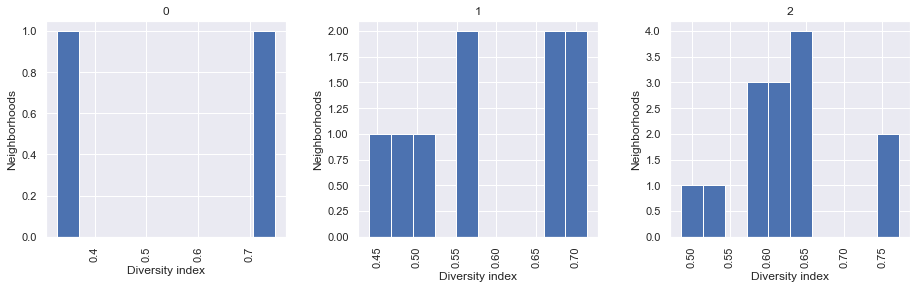

In [45]:
ax = grouped_filtered.hist(column='diversity', by='labels', figsize=(15,4), layout=(1,3))
for a in ax.flatten():
    a.set_xlabel('Diversity index')
    a.set_ylabel('Neighborhoods')
fig = a.figure
fig.savefig('report/hist_prop.pdf', bbox_inches='tight')

This clustering still isn't great. There are still many diverse neighborhoods that are still clustered with less diverse neighborhoods.

### Cluster only using diversity index.

Let's drop all of the venue type columns and perform k-means with the diversity index as the only data.

In [46]:
# drop all but neighborhood and diversity index
only_diversity = grouped_filtered.drop(grouped_filtered.columns.difference(['neighborhood', 'diversity']), axis=1)
only_diversity.head()

neighborhood  diversity
0      Allston   0.634146
1     Back Bay   0.585366
2  Bay Village   0.750000
3  Beacon Hill   0.714286
4     Brighton   0.666667

Text(0, 0.5, 'Sum of squared error')

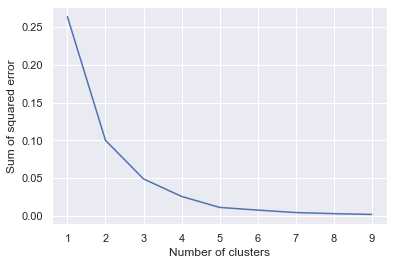

In [47]:
errors = []
ks = list(range(1,10))

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0)\
                .fit(only_diversity.drop(columns=['neighborhood']))
    errors.append(kmeans.inertia_)
    
fig, ax = plt.subplots()
ax.plot(ks, errors)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Sum of squared error')

This plot shows that as the number of clusters increases, the total "distance" between data points and the cluster centers (in "venue type" space) decreases as we include more clusters. The improvement in the fit slows down at the "elbow" of the plot ($k=3$), suggesting that we should cluster the neighborhoods into three groups. Let's add the labels from the 3-cluster results to the dataframe.

In [48]:
kmeans = KMeans(n_clusters=3, random_state=0)\
         .fit(only_diversity.drop(columns=['neighborhood']))

In [49]:
grouped_filtered.drop(columns='labels', inplace=True)
grouped_filtered.insert(1, 'labels', kmeans.labels_)
grouped_filtered.head()

neighborhood  labels  diversity  African Restaurant  American Restaurant  \
0      Allston       1   0.634146                 0.0             0.000000   
1     Back Bay       1   0.585366                 0.0             0.081081   
2  Bay Village       0   0.750000                 0.0             0.000000   
3  Beacon Hill       0   0.714286                 0.0             0.052632   
4     Brighton       0   0.666667                 0.0             0.033333   

   Asian Restaurant  Australian Restaurant  BBQ Joint  Bagel Shop    Bakery  \
0               0.0                    0.0        0.0         0.0  0.026316   
1               0.0                    0.0        0.0         0.0  0.054054   
2               0.0                    0.0        0.0         0.0  0.000000   
3               0.0                    0.0        0.0         0.0  0.052632   
4               0.0                    0.0        0.0         0.0  0.000000   

   ...  Taco Place  Tapas Restaurant  Tea Room  Thai Restaurant  \
0  ...    0.026316          0.000000  0.026316         0.026316   
1  ...    0.000000          0.000000  0.000000         0.000000   
2  ...    0.000000          0.000000  0.000000         0.000000   
3  ...    0.000000          0.000000  0.000000         0.052632   
4  ...    0.000000          0.033333  0.000000         0.033333   

   Theme Restaurant  Turkish Restaurant  Udon Restaurant  \
0               0.0                 0.0              0.0   
1               0.0                 0.0              0.0   
2               0.0                 0.0              0.0   
3               0.0                 0.0              0.0   
4               0.0                 0.0              0.0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Wings Joint  
0                            0.0               0.026316          0.0  
1                            0.0               0.027027          0.0  
2                            0.0               0.000000          0.0  
3                            0.0               0.000000          0.0  
4                            0.0               0.000000          0.0  

[5 rows x 81 columns]

Let's look at the top 5 restaurant types for each neighborhood within each cluster.

In [50]:
df_top5 = pd.DataFrame() # new dataframe for the top 5 restaurant types in each neighborhood

label = 0
for i, (n, label) in enumerate(zip(grouped_filtered['neighborhood'], grouped_filtered['labels'])):
    # sort venues in each neighborhood based on frequency
    freq = grouped_filtered.drop(columns=['neighborhood', 'labels', 'diversity']) \
        .iloc[i, 2:].sort_values(ascending=False)
    dict_top5 = {
        'venue type %i' %j: freq.index[j] for j in range(5)
    }
    dict_top5['neighborhood'] = n
    dict_top5['label'] = label
    df_top5 = df_top5.append(dict_top5, ignore_index=True)

df_top5 = df_top5.astype({'label': int})
df_top5.groupby(['label', 'neighborhood']).first()

venue type 0             venue type 1  \
label neighborhood                                                             
0     Bay Village                Italian Restaurant               Steakhouse   
      Beacon Hill                       Pizza Place              Coffee Shop   
      Brighton                          Pizza Place                     Café   
      Mission Hill                      Pizza Place               Donut Shop   
      Roxbury                  Fast Food Restaurant      Fried Chicken Joint   
      West End                                 Café              Pizza Place   
      West Roxbury             Fast Food Restaurant       Italian Restaurant   
1     Allston                   Fried Chicken Joint        Korean Restaurant   
      Back Bay                          Coffee Shop       Italian Restaurant   
      Charlestown                              Café              Pizza Place   
      Dorchester                        Pizza Place                     Café   
      Downtown                          Coffee Shop       Seafood Restaurant   
      East Boston                Seafood Restaurant             Burger Joint   
      Fenway                            Coffee Shop          Thai Restaurant   
      Hyde Park                         Pizza Place                   Bakery   
      Jamaica Plain                     Coffee Shop                   Bakery   
      Leather District             Asian Restaurant              Coffee Shop   
      Roslindale                             Bakery              Pizza Place   
      South Boston                            Diner  New American Restaurant   
      South Boston Waterfront    Seafood Restaurant       Mexican Restaurant   
      South End                  Italian Restaurant               Donut Shop   
2     Chinatown                  Chinese Restaurant          Bubble Tea Shop   
      Longwood                                 Café              Coffee Shop   
      Mattapan                          Pizza Place     Caribbean Restaurant   
      North End                  Italian Restaurant              Pizza Place   

                                          venue type 2  \
label neighborhood                                       
0     Bay Village                       Sandwich Place   
      Beacon Hill                    French Restaurant   
      Brighton                             Coffee Shop   
      Mission Hill                       Deli / Bodega   
      Roxbury                            Deli / Bodega   
      West End                      Mexican Restaurant   
      West Roxbury                          Bagel Shop   
1     Allston                              Coffee Shop   
      Back Bay                             Salad Place   
      Charlestown                        Deli / Bodega   
      Dorchester                 Vietnamese Restaurant   
      Downtown                            Burger Joint   
      East Boston                          Pizza Place   
      Fenway                        Italian Restaurant   
      Hyde Park                   Caribbean Restaurant   
      Jamaica Plain            New American Restaurant   
      Leather District                  Sandwich Place   
      Roslindale                    Chinese Restaurant   
      South Boston                         Pizza Place   
      South Boston Waterfront              Coffee Shop   
      South End                                 Bakery   
2     Chinatown                                 Bakery   
      Longwood                          Sandwich Place   
      Mattapan                    Fast Food Restaurant   
      North End                                 Bakery   

                                          venue type 3  \
label neighborhood                                       
0     Bay Village                           Food Truck   
      Beacon Hill                       Sandwich Place   
      Brighton                            Burger Joint   
      Mission Hill   

The clustering is drastically different. We can't tell much from the table, except we do note that Chinatown and North End - famously known for Chinese and Italian food, respectively - are grouped together.

Let's examine the distribution of diversity metrics in each cluster.

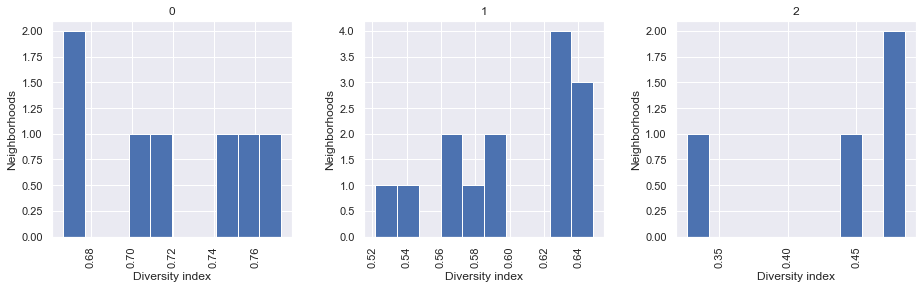

In [51]:
ax = grouped_filtered.hist(column='diversity', by='labels', figsize=(15,4), layout=(1,3))
for a in ax.flatten():
    a.set_xlabel('Diversity index')
    a.set_ylabel('Neighborhoods')
fig = a.figure
fig.savefig('report/hist_diversity.pdf', bbox_inches='tight')

The clusters are now grouped clearly by diversity index, and we can use the clustering to identify diverse food neighborhoods. Let's visualize these on the map to see the geographical distribution of neighborhoods with diverse restaurants.

### Geographic visualization of diverse food neighborhoods

In [52]:
# sort the neighborhoods in the geo dataframe
df = df.sort_values('neighborhood').reset_index(drop=True)
df.head()

neighborhood                                        coordinates  \
0      Allston  [[[[-71.1351744804853, 42.34601463922568], [-7...   
1     Back Bay  [[[[-71.07568860290958, 42.35691673111654], [-...   
2  Bay Village  [[[[-71.06662924918761, 42.34878268384542], [-...   
3  Beacon Hill  [[[[-71.07140935443657, 42.36118675555607], [-...   
4     Brighton  [[[[-71.1351744804853, 42.34601463922568], [-7...   

                                             polygon  \
0  {'type': 'Polygon', 'coordinates': [[[-71.1351...   
1  {'type': 'Polygon', 'coordinates': [[[-71.0756...   
2  {'type': 'Polygon', 'coordinates': [[[-71.0666...   
3  {'type': 'Polygon', 'coordinates': [[[-71.0714...   
4  {'type': 'Polygon', 'coordinates': [[[-71.1351...   

                                    center         area   radius  \
0  [-71.12856230596186, 42.35840515455838]    0.0026496  1029.49   
1  [-71.08053452029958, 42.34986002090343]   0.00105943  650.978   
2  [-71.06903126349887, 42.34910280642528]  7.04128e-05  167.825   
3  [-71.06826238287118, 42.35705004990367]  0.000531102  460.913   
4  [-71.15493529906196, 42.34835662887064]   0.00488274  1397.53   

                                              venues  
0  [{'id': '4cc87fd2bfe1f04d69920875', 'name': 'R...  
1  [{'id': '3fd66200f964a520f6eb1ee3', 'name': 'A...  
2  [{'id': '5b9c4bedbed483002c0dd034', 'name': 'N...  
3  [{'id': '3fd66200f964a52044ec1ee3', 'name': 'T...  
4  [{'id': '57b74d81498edb84968e0ea2', 'name': 'L...

In [53]:
# df.drop(columns='labels', inplace=True)

In [54]:
# Add cluster identification to geographical info dataframe
df.insert(1, 'labels', grouped_filtered['labels'])
df.head()

neighborhood  labels                                        coordinates  \
0      Allston       1  [[[[-71.1351744804853, 42.34601463922568], [-7...   
1     Back Bay       1  [[[[-71.07568860290958, 42.35691673111654], [-...   
2  Bay Village       0  [[[[-71.06662924918761, 42.34878268384542], [-...   
3  Beacon Hill       0  [[[[-71.07140935443657, 42.36118675555607], [-...   
4     Brighton       0  [[[[-71.1351744804853, 42.34601463922568], [-7...   

                                             polygon  \
0  {'type': 'Polygon', 'coordinates': [[[-71.1351...   
1  {'type': 'Polygon', 'coordinates': [[[-71.0756...   
2  {'type': 'Polygon', 'coordinates': [[[-71.0666...   
3  {'type': 'Polygon', 'coordinates': [[[-71.0714...   
4  {'type': 'Polygon', 'coordinates': [[[-71.1351...   

                                    center         area   radius  \
0  [-71.12856230596186, 42.35840515455838]    0.0026496  1029.49   
1  [-71.08053452029958, 42.34986002090343]   0.00105943  650.978   
2  [-71.06903126349887, 42.34910280642528]  7.04128e-05  167.825   
3  [-71.06826238287118, 42.35705004990367]  0.000531102  460.913   
4  [-71.15493529906196, 42.34835662887064]   0.00488274  1397.53   

                                              venues  
0  [{'id': '4cc87fd2bfe1f04d69920875', 'name': 'R...  
1  [{'id': '3fd66200f964a520f6eb1ee3', 'name': 'A...  
2  [{'id': '5b9c4bedbed483002c0dd034', 'name': 'N...  
3  [{'id': '3fd66200f964a52044ec1ee3', 'name': 'T...  
4  [{'id': '57b74d81498edb84968e0ea2', 'name': 'L...

In [55]:
# find average latitude/longitude
lng_avg, lat_avg = df['center'].mean()

m = folium.Map(location=[lat_avg, lng_avg], zoom_start=12)

folium.GeoJson(geodata).add_to(m)

colors = sns.color_palette('deep', 3).as_hex()

# loop over neighborhoods
for i in range(df.shape[0]):
    s = df['neighborhood'][i]
    label = folium.Popup(s)

    folium.CircleMarker(
        df['center'][i][::-1],
        radius=4,
        color=colors[df['labels'][i]],
        fill_color='white',
        fill_opacity=0.5,
        popup=label).add_to(m)  
   
m

In the above map, green markers are the least diverse neighborhoods, while grey markers are the most diverse. There does not seem to be a significantly strong relationship between geographical location and restaurant diversity. The west half of downtown tends to be more diverse than the right half, but there are also a number of diverse neighborhoods further from the city center.